In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 업로드
from google.colab import files
uploaded = files.upload()

Saving 202501.xlsx to 202501 (4).xlsx


In [87]:
# 데이터 불러오기
df = pd.read_excel('202501.xlsx')

In [88]:
# 시간 데이터 변환
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'], errors='coerce')

In [89]:
# Hour 컬럼 생성
df['Hour'] = df['Pump-Begin'].dt.hour

In [90]:
# 금속 컬럼 정의
metal_cols = [col for col in df.columns if '(ng/m3)' in col]

In [91]:
# 숫자형 변환
df[pm25_col] = pd.to_numeric(df[pm25_col], errors='coerce')
for metal in metal_cols:
    df[metal] = pd.to_numeric(df[metal], errors='coerce')

# 음수값 제거
df[pm25_col] = df[pm25_col].apply(lambda x: x if x >= 0 else np.nan)
for metal in metal_cols:
    df[metal] = df[metal].apply(lambda x: x if x >= 0 else np.nan)

# 이상치 제거 (평균 ± 3표준편차)
for col in [pm25_col] + metal_cols:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = df[col].apply(lambda x: x if (mean_val - 3*std_val <= x <= mean_val + 3*std_val) else np.nan)

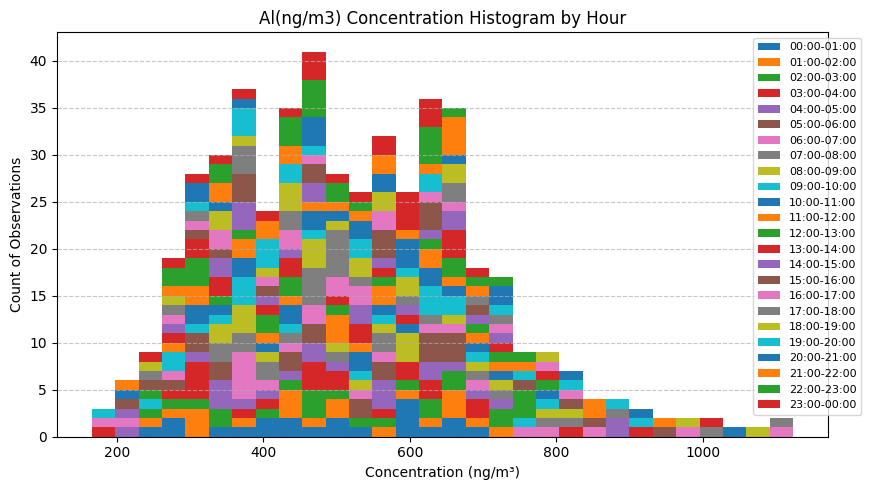

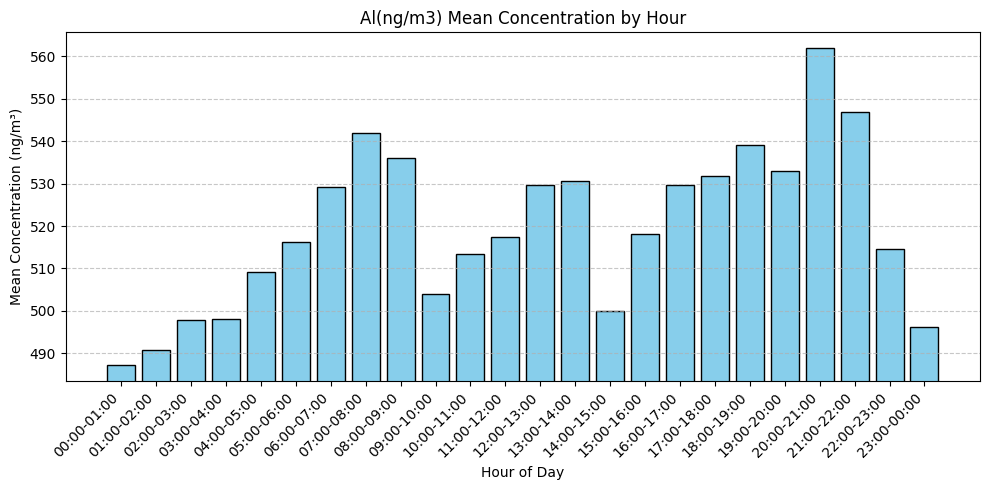

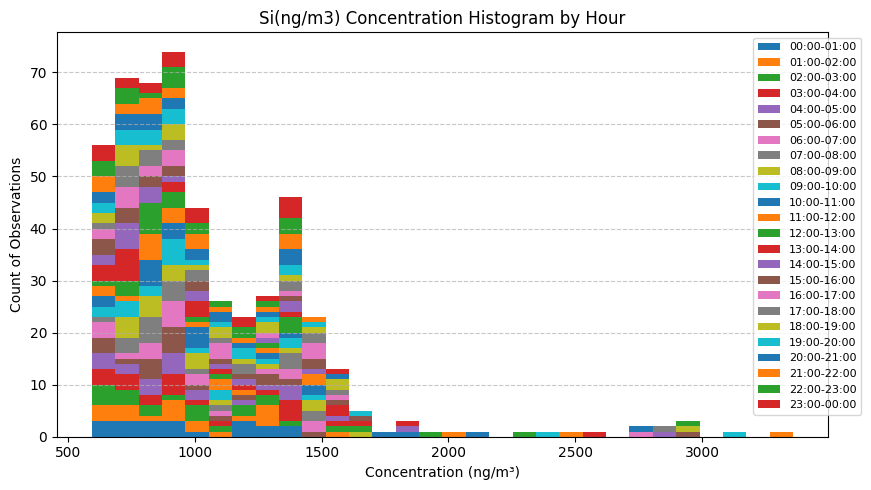

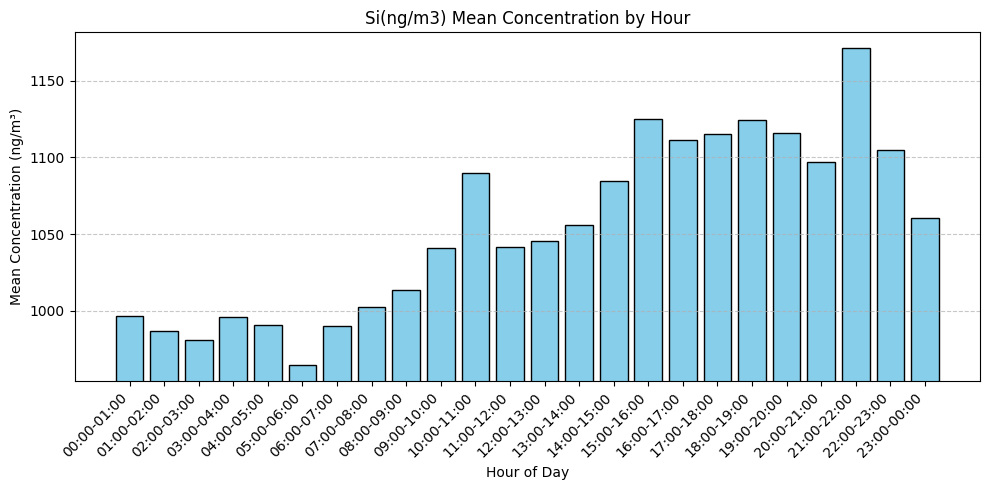

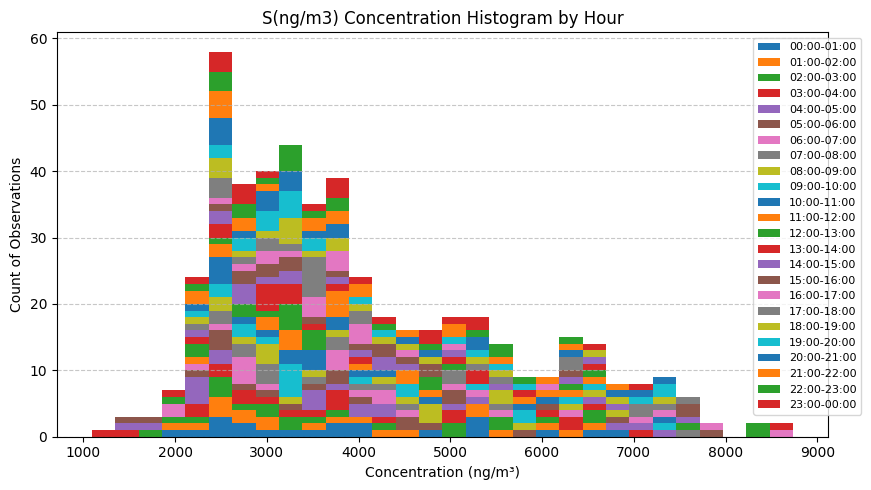

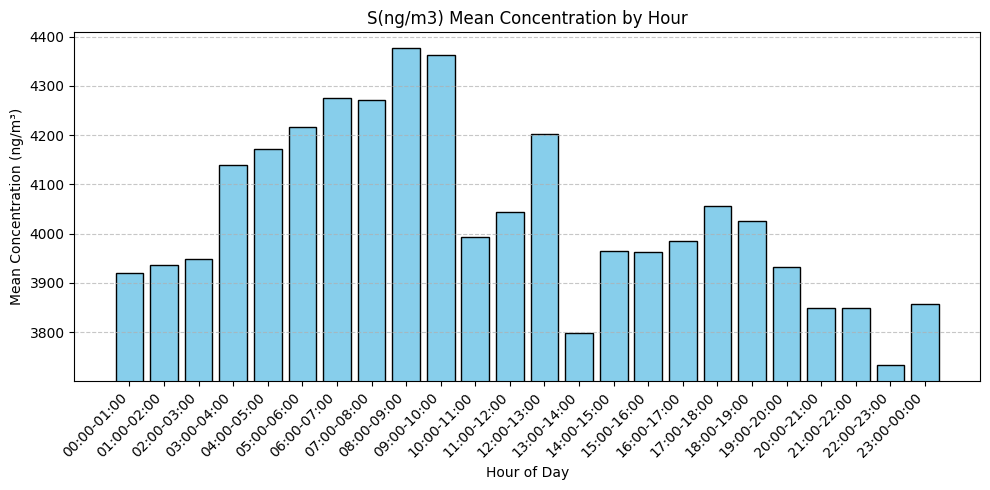

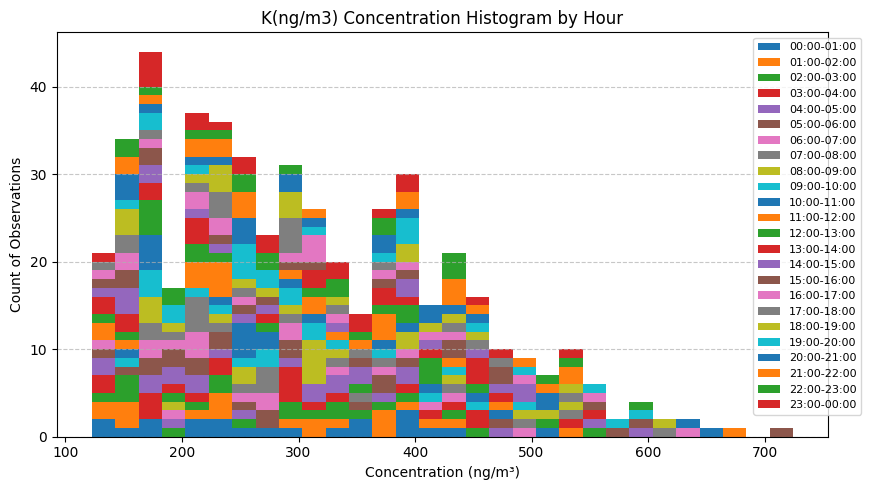

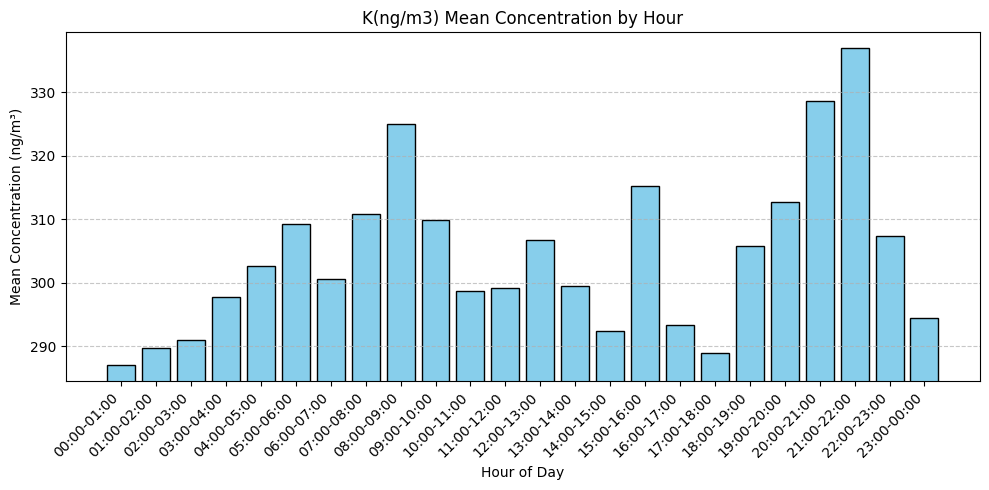

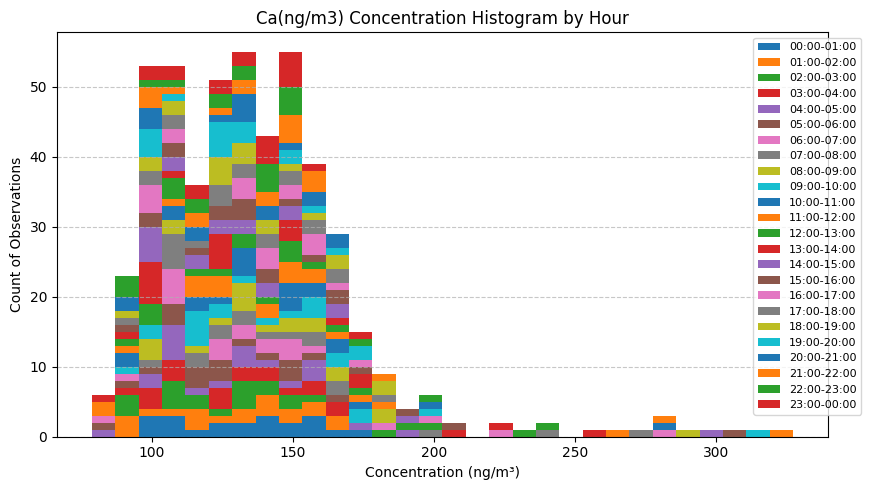

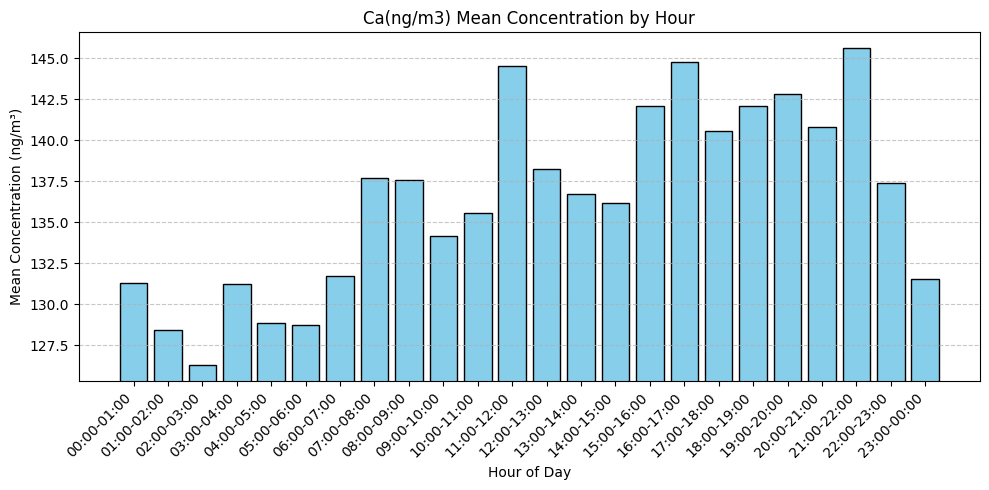

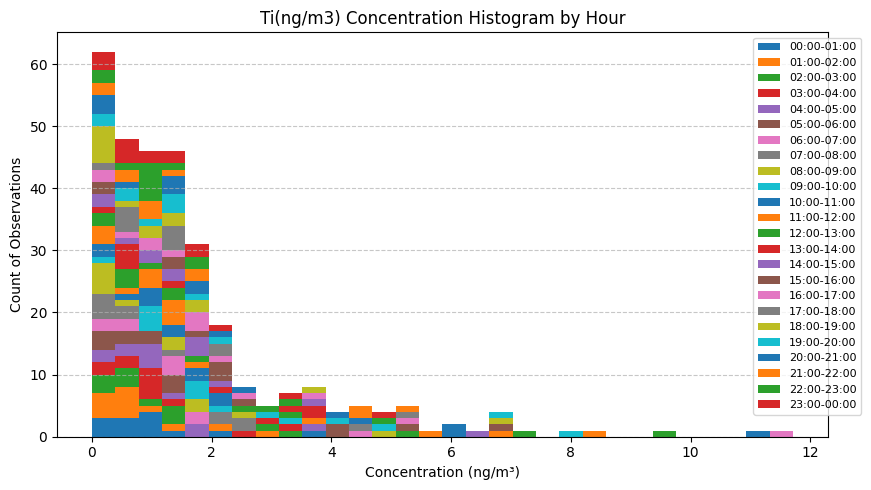

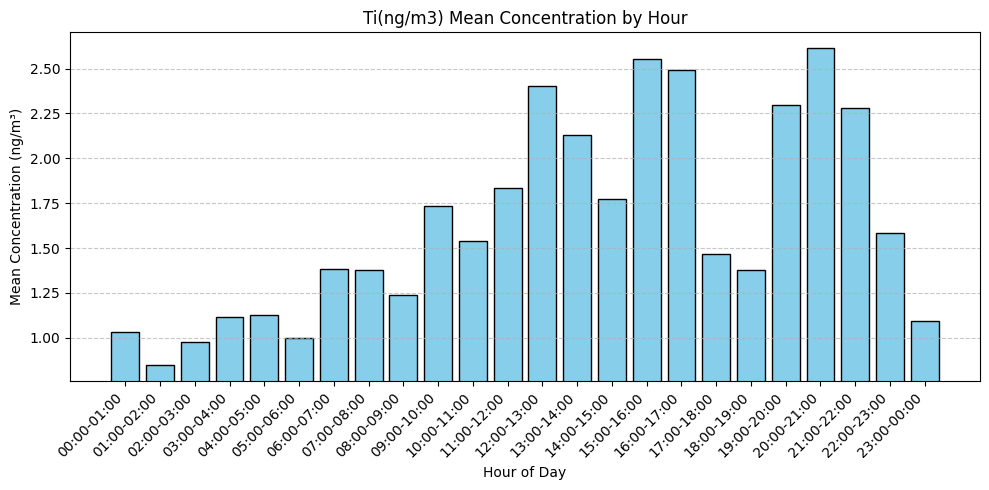

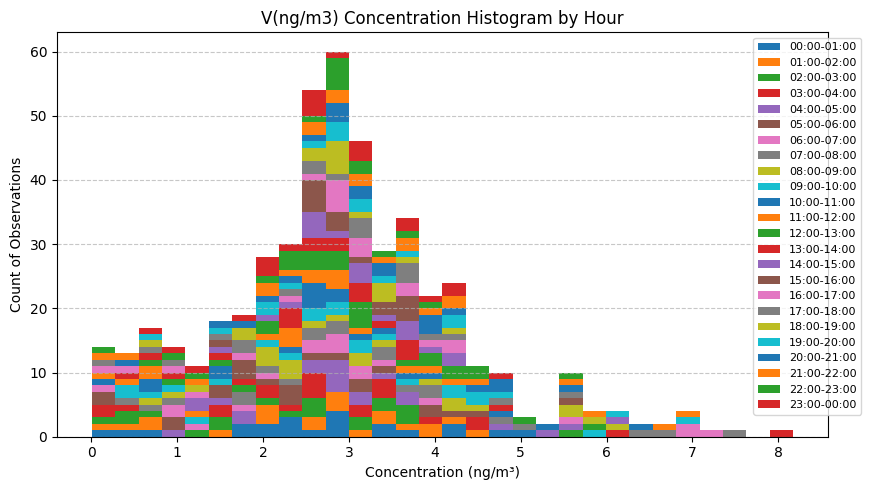

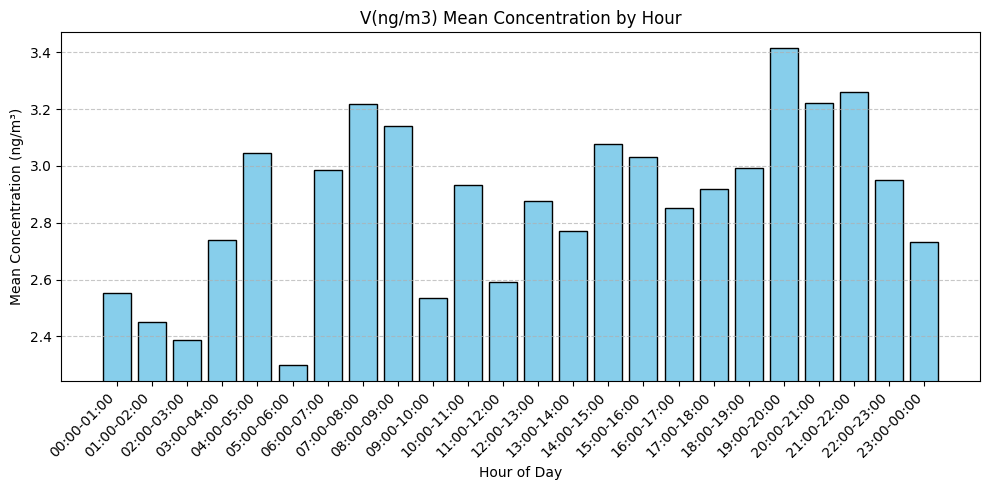

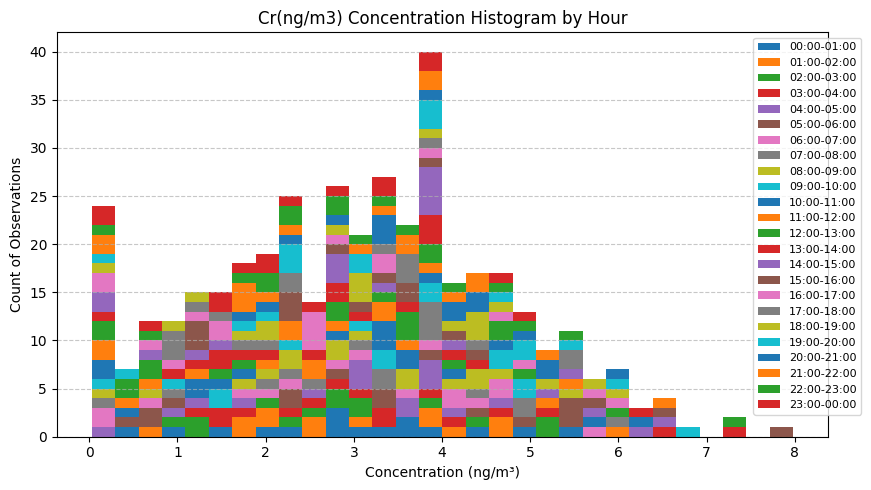

In [ ]:
def plot_hourly_hist_and_avg(df, column_name, unit):
    # 시간 라벨 생성
    hour_labels = [f"{str(h).zfill(2)}:00-{str((h+1)%24).zfill(2)}:00" for h in range(24)]
    df['Hour_Label'] = df['Hour'].map({h: label for h, label in enumerate(hour_labels)})

    # 1. 시간대별 스택형 히스토그램
    plt.figure(figsize=(10,5))
    plt.hist([df[df['Hour'] == h][column_name].dropna() for h in range(24)],
        bins=30,
        stacked=True,
        label=hour_labels)
    plt.title(f'{column_name} Concentration Histogram by Hour')
    plt.xlabel(f'Concentration ({unit})')
    plt.ylabel('Count of Observations')
    plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 2. 시간대별 평균 막대그래프
    hourly_avg = df.groupby('Hour_Label')[column_name].mean()
    plt.figure(figsize=(10,5))
    plt.bar(hourly_avg.index, hourly_avg.values, color='skyblue', edgecolor='black')
    plt.title(f'{column_name} Mean Concentration by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel(f'Mean Concentration ({unit})')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # y축 범위 확장
    ymin = hourly_avg.min() - (hourly_avg.max() - hourly_avg.min()) * 0.05
    ymax = hourly_avg.max() + (hourly_avg.max() - hourly_avg.min()) * 0.05
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    plt.show()

# 금속 분석
for metal in metal_cols:
    plot_hourly_hist_and_avg(df, metal, 'ng/m³')